#  Pneumonia Classification Task Using Keras

In [3]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, Convolution2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

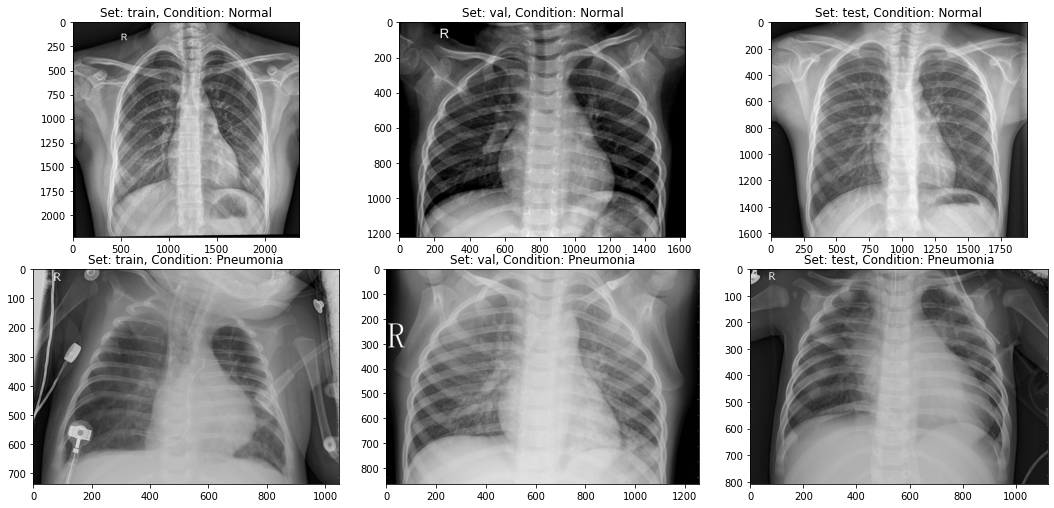

In [4]:
input_path = './images/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title(f'Set: {_set}, Condition: Normal')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title(f'Set: {_set}, Condition: Pneumonia')

In [5]:
for _set in ['train', 'val', 'test']: 
    n_normal = len(os.listdir(input_path + _set + '/NORMAL')) 
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA')) 
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


In [6]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [7]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (150, 150, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
ihist = classifier.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 [==============================] - 101s 622ms/step - loss: 0.4878 - accuracy: 0.7874 - val_loss: 0.4306 - val_accuracy: 0.8207
Epoch 2/10
163/163 [==============================] - 82s 503ms/step - loss: 0.3092 - accuracy: 0.8744 - val_loss: 0.3646 - val_accuracy: 0.8388
Epoch 3/10
163/163 [==============================] - 103s 634ms/step - loss: 0.2689 - accuracy: 0.8871 - val_loss: 0.4418 - val_accuracy: 0.8092
Epoch 4/10
163/163 [==============================] - 93s 570ms/step - loss: 0.2508 - accuracy: 0.8955 - val_loss: 0.3073 - val_accuracy: 0.8717
Epoch 5/10
163/163 [==============================] - 77s 472ms/step - loss: 0.2470 - accuracy: 0.8974 - val_loss: 0.2643 - val_accuracy: 0.8931
Epoch 6/10
163/163 [==============================] - 76s 466ms/step - loss: 0.2208 - accuracy: 0.9105 - val_loss: 0.4188 - val_accuracy: 0.8224
Epoch 7/10
163/163 [==============================] 

0 accuracy
1 loss


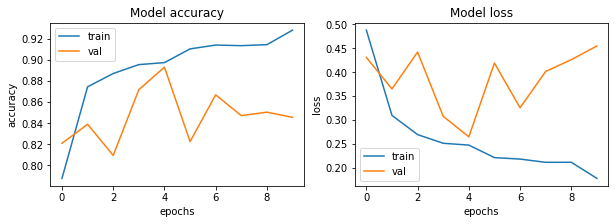

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    print(i, met)
    ax[i].plot(ihist.history[met])
    ax[i].plot(ihist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = classifier.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('')
print('TEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {2*precision*recall/(precision+recall)}')

print('\nTRAIN METRIC ----------------------')
print(f'Train acc: {ihist.history["accuracy"][-1] } ' )

CONFUSION MATRIX ------------------
[[147  87]
 [  7 383]]

TEST METRICS ----------------------
Accuracy: 84.93589743589743
Precision: 81.48936170212767
Recall: 98.2051282051282
F1-score: 89.06976744186048

TRAIN METRIC ----------------------
Train acc: 0.9282975196838379 


This links to a way more complex solution!
Try it out as well!

https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8